In [1]:
# CÉLULA 1: EXTRAÇÃO DO POSTGRESQL E ANÁLISE INICIAL (EDA - PASSO 1 DO ARTIGO)

# --- 1. IMPORTAÇÕES E SETUP ---
import pandas as pd
import os
from sqlalchemy import create_engine, text
import numpy as np # Necessário para df.describe() e outras análises
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder # Para células futuras

sns.set_theme(style="whitegrid")

# --- 2. CONFIGURAÇÃO DE CONEXÃO COM POSTGRESQL ---
# As variáveis são lidas do ambiente Docker injetado pelo docker-compose
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_DB = os.environ.get("POSTGRES_DB")
DB_HOST = os.environ.get("DB_HOST") 
RAW_TABLE_NAME = "heart_disease_raw" # A tabela que o FastAPI carrega

DATABASE_URL = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DB_HOST}:5432/{POSTGRES_DB}"
engine = create_engine(DATABASE_URL)

# --- 3. AÇÃO CHAVE: LER A TABELA PERSISTIDA PARA O DATAFRAME 'df' ---
try:
    # Lendo o DataFrame diretamente da tabela que contém os dados brutos
    df = pd.read_sql(text(f"SELECT * FROM {RAW_TABLE_NAME}"), engine)
    
    print(f"VERIFICAÇÃO: DataFrame 'df' lido com sucesso da tabela PostgreSQL: {RAW_TABLE_NAME}")
    print(f"Total de linhas para limpeza: {len(df)}")

except Exception as e:
    print("\n" + "="*50)
    print("ERRO CRÍTICO AO LER DO POSTGRESQL!")
    print("O FastAPI /load_raw_to_db/ falhou ou o pg_db não está pronto.")
    print(f"Erro: {e}")
    print("="*50)
    exit()

# --- 4. ANÁLISE ESTATÍSTICA (PASSO 1 DO PRÉ-PROCESSAMENTO) ---
print("\n" + "="*50)
print("ANÁLISE ESTATÍSTICA (ENTENDIMENTO DOS DADOS)")
print("="*50)
print(df.describe())
print("\nVerificando valores nulos:")
print(df.isnull().sum())

VERIFICAÇÃO: DataFrame 'df' lido com sucesso da tabela PostgreSQL: heart_disease_raw
Total de linhas para limpeza: 1190

ANÁLISE ESTATÍSTICA (ENTENDIMENTO DOS DADOS)
               age          sex  chest pain type  resting bp s  cholesterol  \
count  1190.000000  1190.000000      1190.000000   1190.000000  1190.000000   
mean     53.720168     0.763866         3.232773    132.153782   210.363866   
std       9.358203     0.424884         0.935480     18.368823   101.420489   
min      28.000000     0.000000         1.000000      0.000000     0.000000   
25%      47.000000     1.000000         3.000000    120.000000   188.000000   
50%      54.000000     1.000000         4.000000    130.000000   229.000000   
75%      60.000000     1.000000         4.000000    140.000000   269.750000   
max      77.000000     1.000000         4.000000    200.000000   603.000000   

       fasting blood sugar  resting ecg  max heart rate  exercise angina  \
count          1190.000000  1190.000000     11

In [2]:
df.isnull().sum()

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

In [3]:
# Nesse dataset foi identificadas 272 duplicatas, dessa forma será necessário a remoção

In [4]:
n_duplicates = df.duplicated().sum()
print(f"\nTotal de linhas duplicadas: {n_duplicates}")


Total de linhas duplicadas: 272


In [5]:
# Avaliação de Outliers


ANÁLISE E VISUALIZAÇÃO DE OUTLIERS POR IQR
Outliers detectados em resting bp s: 37 instâncias.
 - Limites (IQR): Inferior=90.00, Superior=170.00


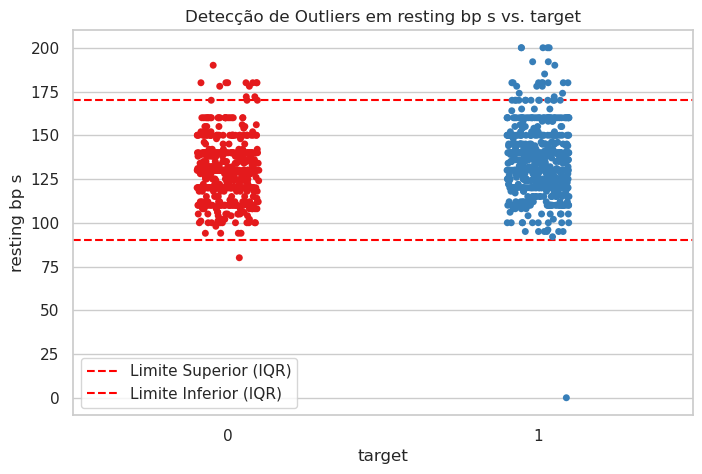

Outliers detectados em cholesterol: 193 instâncias.
 - Limites (IQR): Inferior=65.38, Superior=392.38


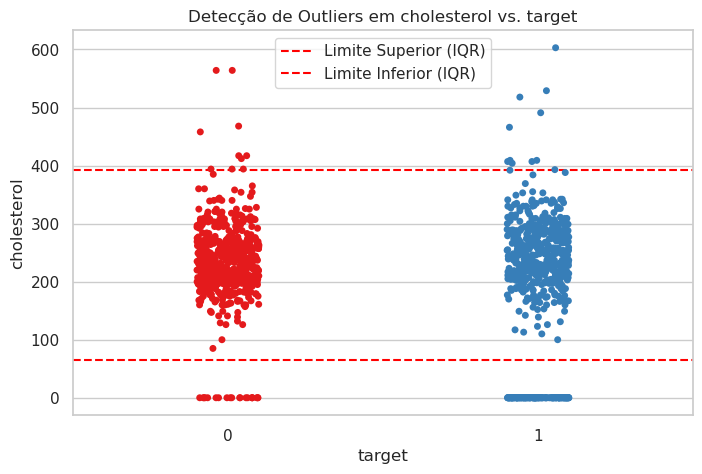

Outliers detectados em oldpeak: 11 instâncias.
 - Limites (IQR): Inferior=-2.40, Superior=4.00


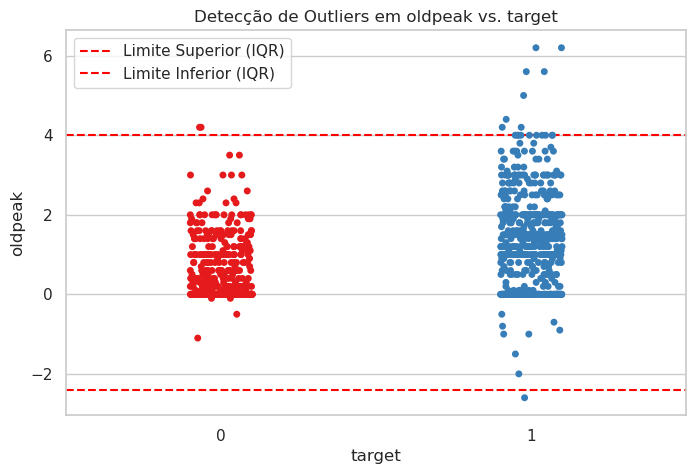

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Definir a variável alvo (conforme o artigo, é HeartDisease)
TARGET_COLUMN = 'target' 

# Colunas numéricas importantes para análise de outlier
# O artigo menciona RestingBP, Cholesterol, e Oldpeak.
features_to_check = ['resting bp s', 'cholesterol', 'oldpeak']

def detect_outliers_iqr(df, column):
    """Calcula os limites IQR e retorna os outliers extremos."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Limites para detecção de outliers (1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Retorna as linhas que são outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Retorna a contagem, os limites e o DataFrame de outliers
    return len(outliers), lower_bound, upper_bound, outliers

print("\n" + "="*60)
print("ANÁLISE E VISUALIZAÇÃO DE OUTLIERS POR IQR")
print("="*60)

for col in features_to_check:
    if col not in df.columns:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame.")
        continue

    n_outliers, lower_bound, upper_bound, outliers_df = detect_outliers_iqr(df, col)

    if n_outliers > 0:
        print(f"Outliers detectados em {col}: {n_outliers} instâncias.")
        print(f" - Limites (IQR): Inferior={lower_bound:.2f}, Superior={upper_bound:.2f}")

        # --- Geração do Gráfico de Dispersão (Strip Chart) ---
        
        plt.figure(figsize=(8, 5))
        
        # Cria o gráfico de dispersão (Strip Plot) para visualizar os dados e outliers
        sns.stripplot(x=TARGET_COLUMN, y=col, data=df, hue=TARGET_COLUMN, 
                      palette="Set1", jitter=True, legend=False)
        
        # Adiciona linhas para mostrar os limites de detecção do IQR
        plt.axhline(y=upper_bound, color='red', linestyle='--', label='Limite Superior (IQR)')
        plt.axhline(y=lower_bound, color='red', linestyle='--', label='Limite Inferior (IQR)')
        
        # Destaca os pontos de outliers (opcional, dependendo da visualização)
        # sns.scatterplot(x=outliers_df[TARGET_COLUMN], y=outliers_df[col], color='black', marker='X', s=100, label='Outliers')

        plt.title(f'Detecção de Outliers em {col} vs. {TARGET_COLUMN}')
        plt.xlabel(TARGET_COLUMN)
        plt.ylabel(col)
        plt.legend(loc='best')
        plt.show()
        
    else:
        print(f"Nenhum outlier extremo detectado em {col} pelo método IQR.")

In [7]:
# CÉLULA 1: VERIFICAÇÃO DE VALORES ZERO NO COLESTEROL

# 1. Contar quantas instâncias têm Colesterol = 0
zero_cholesterol_count = (df['cholesterol'] == 0).sum()

print(f"Total de instâncias com Colesterol = 0: {zero_cholesterol_count}")

# 2. Verificar se a anomalia existe
if zero_cholesterol_count > 0:
    print("\nANOMALIA CONFIRMADA: Há valores de Colesterol igual a 0 que precisam ser substituídos pela mediana.")
else:
    print("\nNenhum valor de Colesterol zero encontrado. O dataset está limpo nesta anomalia.")

Total de instâncias com Colesterol = 0: 172

ANOMALIA CONFIRMADA: Há valores de Colesterol igual a 0 que precisam ser substituídos pela mediana.


In [8]:
# No artigo foram encontrados 170 valores 0 no colesterol, o que é impossível, porém no nosso foram encontrados 172, valor bem próximo.

In [9]:
# CÉLULA 2: SUBSTITUIÇÃO PELA MEDIANA (APENAS SE HOUVER ZEROS)

if zero_cholesterol_count > 0:
    
    # 1. Calcular a Mediana da Coluna Cholesterol (ignorando os zeros, para garantir que não afetem a mediana se necessário, mas o Pandas geralmente ignora NaNs)
    # Nota: Usamos o DataFrame original (df)
    median_cholesterol = df['cholesterol'].median()

    # 2. Substituir os valores 0 pela Mediana calculada
    df['cholesterol'] = df['cholesterol'].replace(0, median_cholesterol)

    print(f"\n--- LIMPEZA EXECUTADA ---")
    print(f"Mediana do Colesterol utilizada: {median_cholesterol:.2f}")
    print(f"Instâncias com Colesterol 0 foram substituídas pela mediana.")
    
    # 3. Verificação (Confirma que não há mais zeros)
    new_zero_count = (df['cholesterol'] == 0).sum()
    print(f"Nova contagem de Colesterol = 0: {new_zero_count}")
    
    # Se a contagem for zero, a limpeza funcionou!

else:
    print("\nNenhuma substituição necessária. Avançando para a próxima etapa.")


--- LIMPEZA EXECUTADA ---
Mediana do Colesterol utilizada: 229.00
Instâncias com Colesterol 0 foram substituídas pela mediana.
Nova contagem de Colesterol = 0: 0


In [10]:
# Remocao de outliers

In [11]:
# CÉLULA: REMOÇÃO DE OUTLIERS CONFORME ARTIGO (RestingBP e Cholesterol)

print("--- REMOÇÃO DE OUTLIERS EXTREMOS (RestingBP e Cholesterol) ---")

# Criar uma cópia do DataFrame antes da remoção para rastrear o tamanho
initial_size = len(df)
df_clean = df.copy()

# Regra 1: Remoção de Outliers em RestingBP
# O artigo indica a remoção de 2 outliers. A Figura 4 diz que os outliers são "Valores menores que 80"[cite: 273].
resting_bp_lower_limit = 80
df_clean = df_clean[df_clean['resting bp s'] >= resting_bp_lower_limit]

removed_resting_bp = initial_size - len(df_clean)
initial_size = len(df_clean) # Atualiza o tamanho

# Regra 2: Remoção de Outliers Extremos em Cholesterol
# O artigo indica a remoção de 8 outliers. A Figura 5 diz que os outliers são "Valores maiores que 450 e menores que 100"[cite: 275].
cholesterol_lower_limit = 100
cholesterol_upper_limit = 450

df_clean = df_clean[(df_clean['cholesterol'] >= cholesterol_lower_limit) & (df_clean['cholesterol'] <= cholesterol_upper_limit)]

removed_cholesterol = initial_size - len(df_clean)

# Regra 3: Oldpeak
# O artigo não remove outliers em Oldpeak[cite: 209]. Apenas os extemos foram tratados[cite: 210].

final_size = len(df_clean)

print(f"Instâncias removidas em RestingBP (< {resting_bp_lower_limit}): {removed_resting_bp}")
print(f"Instâncias removidas em Cholesterol (<\ {cholesterol_lower_limit} ou > {cholesterol_upper_limit}): {removed_cholesterol}")
print(f"Total de linhas no dataset original: {len(df)}")
print(f"Total de linhas no dataset após limpeza: {final_size}")

# Atualiza o DataFrame principal para o restante do pipeline
df = df_clean

--- REMOÇÃO DE OUTLIERS EXTREMOS (RestingBP e Cholesterol) ---
Instâncias removidas em RestingBP (< 80): 1
Instâncias removidas em Cholesterol (<\ 100 ou > 450): 10
Total de linhas no dataset original: 1190
Total de linhas no dataset após limpeza: 1179


In [12]:
# Remover duplicatas

In [13]:
# CÉLULA: VERIFICAÇÃO E REMOÇÃO DE DUPLICATAS

print("--- VERIFICAÇÃO E REMOÇÃO DE DUPLICATAS ---")

# 1. Contar Duplicatas
duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f"ATENÇÃO: {duplicate_count} linhas duplicadas encontradas (o artigo diz que não há, mas a verificação encontrou!).")
    
    # 2. Remover as Duplicatas (mantendo a primeira ocorrência)
    df.drop_duplicates(inplace=True)
    
    print(f"Linhas duplicadas removidas com sucesso.")
    print(f"Novo tamanho do DataFrame: {len(df)}")

else:
    print("Nenhuma linha duplicada encontrada. O DataFrame está limpo.")

--- VERIFICAÇÃO E REMOÇÃO DE DUPLICATAS ---
ATENÇÃO: 271 linhas duplicadas encontradas (o artigo diz que não há, mas a verificação encontrou!).
Linhas duplicadas removidas com sucesso.
Novo tamanho do DataFrame: 908


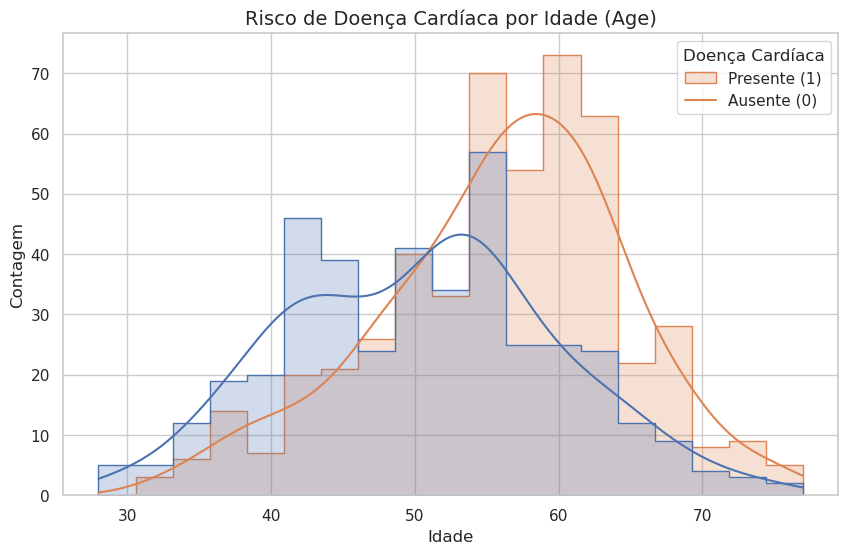

In [14]:
# GRÁFICO 1: RISCO VS. IDADE (Figura 6)
plt.figure(figsize=(10, 6))

# Histograma e KDE comparando a distribuição de 'Age' para cada classe de 'HeartDisease'
sns.histplot(
    data=df, 
    x='age', 
    hue='target', 
    kde=True, 
    palette='deep', 
    element='step'
)

plt.title('Risco de Doença Cardíaca por Idade (Age)', fontsize=14)
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.legend(title='Doença Cardíaca', labels=['Presente (1)', 'Ausente (0)'])
plt.show()

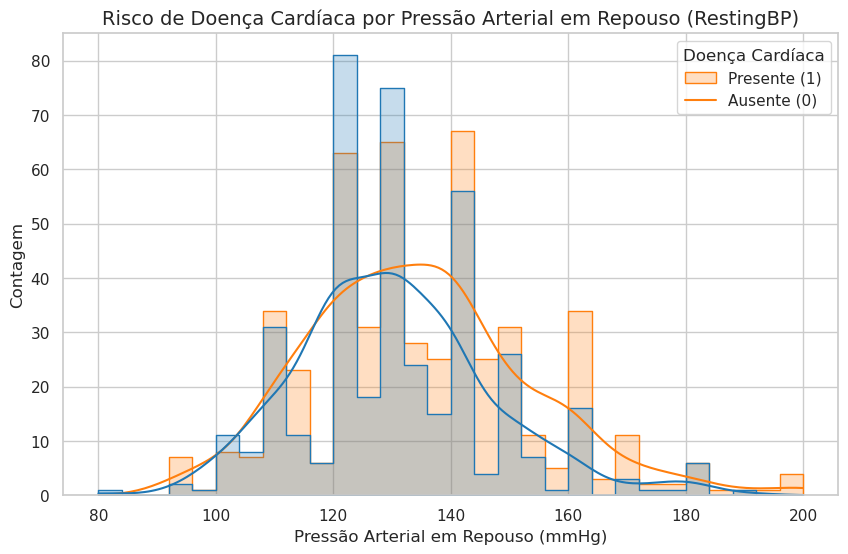

In [15]:
# GRÁFICO 2: RISCO VS. PRESSÃO ARTERIAL (Figura 7)
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df, 
    x='resting bp s', 
    hue='target', 
    kde=True, 
    palette='tab10', 
    element='step'
)

plt.title('Risco de Doença Cardíaca por Pressão Arterial em Repouso (RestingBP)', fontsize=14)
plt.xlabel('Pressão Arterial em Repouso (mmHg)')
plt.ylabel('Contagem')
plt.legend(title='Doença Cardíaca', labels=['Presente (1)', 'Ausente (0)'])
plt.show()

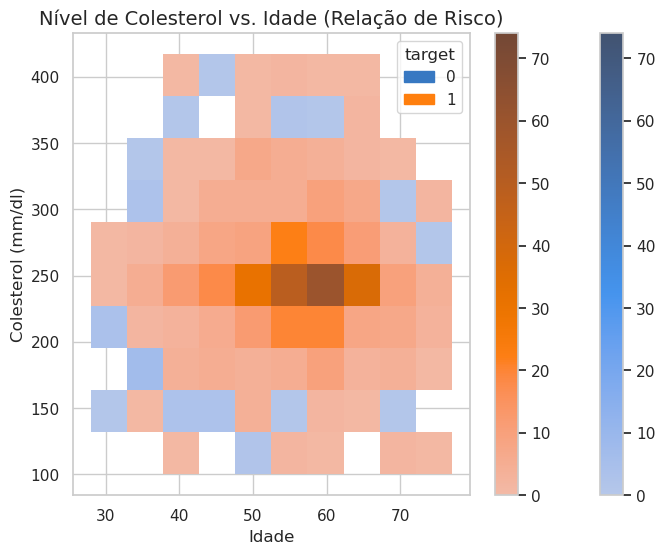

In [16]:
# GRÁFICO 3: COLESTEROL VS. IDADE (Figura 8)
plt.figure(figsize=(8, 6))

# Usamos um gráfico de agregação (scatterplot com bins) para mostrar a densidade
sns.histplot(
    data=df, 
    x='age', 
    y='cholesterol', 
    hue='target', 
    bins=10, 
    cbar=True,
    palette=['#3778c2', '#ff7f0e'] # Azul para 0, Laranja para 1
)

plt.title('Nível de Colesterol vs. Idade (Relação de Risco)', fontsize=14)
plt.xlabel('Idade')
plt.ylabel('Colesterol (mm/dl)')
plt.show()

/tmp/ipykernel_11391/4249536221.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


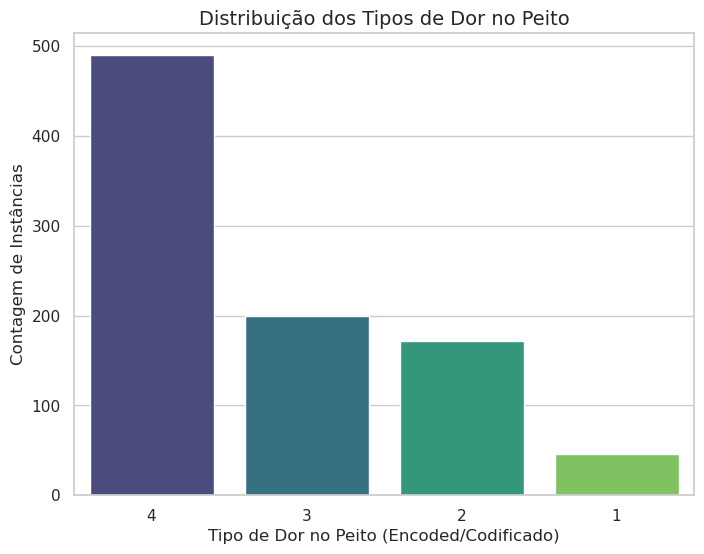

In [17]:
# GRÁFICO 4: TIPO DE DOR NO PEITO (Figura 9)
plt.figure(figsize=(8, 6))

# Se a coluna 'ChestPainType' ainda for categórica (string), use-a diretamente
# Se ela já foi Label Encoded (como no seu caso), o eixo X terá números.
sns.countplot(
    data=df, 
    x='chest pain type', 
    order=df['chest pain type'].value_counts().index,
    palette='viridis'
)

plt.title('Distribuição dos Tipos de Dor no Peito', fontsize=14)
plt.xlabel('Tipo de Dor no Peito (Encoded/Codificado)')
plt.ylabel('Contagem de Instâncias')
plt.show()

In [18]:
# Data encoding

In [19]:
# CÉLULA: CODIFICAÇÃO DE DADOS (Label Encoder)

from sklearn.preprocessing import LabelEncoder

print("--- APLICANDO LABEL ENCODING ---")

# As 5 variáveis categóricas conforme o artigo:
categorical_cols = ['sex', 'chest pain type', 'resting ecg', 'exercise angina', 'ST slope'] 

# Instanciar o Label Encoder
le = LabelEncoder()

# Aplicar o Label Encoder em cada coluna
for col in categorical_cols:
    if col in df.columns:
        print(f"Codificando a coluna: {col}")
        
        # O LabelEncoder funciona com dados de texto/object.
        # Ele converte M/F para 0/1, TA/ATA/NAP/ASY para 0/1/2/3, etc.
        df[col] = le.fit_transform(df[col])
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame.")


print("\nCodificação concluída.")

# Visualizar as primeiras linhas para confirmar a conversão
print("Primeiras linhas do DataFrame após Encoding:")
print(df.head())
print("\nVerificando tipos de dados após Encoding (devem ser Int64/Int32):")
print(df[categorical_cols].dtypes)

--- APLICANDO LABEL ENCODING ---
Codificando a coluna: sex
Codificando a coluna: chest pain type
Codificando a coluna: resting ecg
Codificando a coluna: exercise angina
Codificando a coluna: ST slope

Codificação concluída.
Primeiras linhas do DataFrame após Encoding:
   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                1           140          289                    0   
1   49    0                2           160          180                    0   
2   37    1                1           130          283                    0   
3   48    0                3           138          214                    0   
4   54    1                2           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1     

In [20]:
# CÉLULA: DATA SCALING (StandardScaler) E LOAD NO POSTGRESQL

from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine, text
import os

print("--- 1. APLICANDO DATA SCALING (StandardScaler) ---")

# Identificar todas as colunas de Features (excluindo a variável alvo)
# Assumimos que a variável alvo é 'HeartDisease' (conforme Tabela 2 do artigo)
TARGET_COLUMN = 'target'
features_to_scale = df.columns.drop(TARGET_COLUMN) 

# Cria uma cópia para aplicar a transformação
df_final_scaled = df.copy()

# Instanciar e aplicar o Standard Scaler
scaler = StandardScaler()

# Aplica o fit_transform APENAS nas colunas de features
df_final_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("Escalonamento Standard concluído. Dados prontos para o ML.")
print(df_final_scaled.head())

--- 1. APLICANDO DATA SCALING (StandardScaler) ---
Escalonamento Standard concluído. Dados prontos para o ML.
        age       sex  chest pain type  resting bp s  cholesterol  \
0 -1.436363  0.516128        -1.339139      0.409594     1.052344   
1 -0.481359 -1.937505        -0.266883      1.518455    -1.265402   
2 -1.754698  0.516128        -1.339139     -0.144836     0.924761   
3 -0.587470 -1.937505         0.805373      0.298708    -0.542436   
4  0.049199  0.516128        -0.266883      0.964025    -0.946447   

   fasting blood sugar  resting ecg  max heart rate  exercise angina  \
0            -0.550205    -0.753901        1.380468        -0.827406   
1            -0.550205    -0.753901        0.751928        -0.827406   
2            -0.550205     0.486212       -1.526527        -0.827406   
3            -0.550205    -0.753901       -1.133690         1.208596   
4            -0.550205    -0.753901       -0.583718        -0.827406   

    oldpeak  ST slope  target  
0 -0.83268

In [21]:
# --- 2. CARREGAMENTO NO POSTGRESQL (Estruturação) ---
import os
# Verifique se esta linha está na Célula 1 ou em uma célula anterior:
from sqlalchemy import create_engine, text

print("\n--- CARREGANDO DADOS ESTRUTURADOS NO POSTGRESQL ---")

# CÉLULA 3: CONEXÃO E CARREGAMENTO NO POSTGRESQL (LOAD)

# Variáveis de Conexão com PostgreSQL
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_DB = os.environ.get("POSTGRES_DB")
DB_HOST = os.environ.get("DB_HOST") 

DATABASE_URL = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DB_HOST}:5432/{POSTGRES_DB}"
TABLE_NAME = "clean_heart_data"

try:
    # Este comando REQUIERE que 'create_engine' tenha sido importado!
    engine = create_engine(DATABASE_URL)
    
    # Carregar o DataFrame escalado (df_final_scaled)
    df_final_scaled.to_sql(
        TABLE_NAME, 
        engine, 
        if_exists='replace',
        index=False 
    )
    
    print(f"\nDados finais carregados no PostgreSQL na tabela: {TABLE_NAME}")

except Exception as e:
    # Se der erro aqui, é problema de rede/conexão, não de importação.
    print(f"ERRO CRÍTICO no PostgreSQL: {e}")


--- CARREGANDO DADOS ESTRUTURADOS NO POSTGRESQL ---

Dados finais carregados no PostgreSQL na tabela: clean_heart_data


In [22]:
# lendo as tabelas do postgree


In [23]:
# CÉLULA: VERIFICAÇÃO DE CARREGAMENTO NO POSTGRESQL

import pandas as pd
from sqlalchemy import create_engine, text
import os

# 1. Configurar a conexão
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_DB = os.environ.get("POSTGRES_DB")
DB_HOST = os.environ.get("DB_HOST") 
TABLE_NAME = "clean_heart_data" # Nome da tabela salva

DATABASE_URL = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DB_HOST}:5432/{POSTGRES_DB}"
engine = create_engine(DATABASE_URL)

try:
    # 2. Consultar o número total de linhas na tabela
    count_query = text(f"SELECT COUNT(*) FROM {TABLE_NAME}")
    total_rows = pd.read_sql(count_query, engine).iloc[0, 0]

    # 3. Consultar as 5 primeiras linhas (para inspecionar a escala e a codificação)
    check_query = text(f"SELECT * FROM {TABLE_NAME} LIMIT 5")
    df_check = pd.read_sql(check_query, engine)

    print(f"VERIFICAÇÃO CONCLUÍDA:")
    print(f"Total de linhas salvas na tabela '{TABLE_NAME}': {total_rows}")
    print("\nPrimeiras 5 linhas (devem estar escalonadas/codificadas):")
    print(df_check.head())

except Exception as e:
    print(f"ERRO AO LER DO POSTGRESQL: {e}")

VERIFICAÇÃO CONCLUÍDA:
Total de linhas salvas na tabela 'clean_heart_data': 908

Primeiras 5 linhas (devem estar escalonadas/codificadas):
        age       sex  chest pain type  resting bp s  cholesterol  \
0 -1.436363  0.516128        -1.339139      0.409594     1.052344   
1 -0.481359 -1.937505        -0.266883      1.518455    -1.265402   
2 -1.754698  0.516128        -1.339139     -0.144836     0.924761   
3 -0.587470 -1.937505         0.805373      0.298708    -0.542436   
4  0.049199  0.516128        -0.266883      0.964025    -0.946447   

   fasting blood sugar  resting ecg  max heart rate  exercise angina  \
0            -0.550205    -0.753901        1.380468        -0.827406   
1            -0.550205    -0.753901        0.751928        -0.827406   
2            -0.550205     0.486212       -1.526527        -0.827406   
3            -0.550205    -0.753901       -1.133690         1.208596   
4            -0.550205    -0.753901       -0.583718        -0.827406   

    oldpeak  